# 1. Import Data

In [1]:
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings("ignore")

import time
import datetime

#libraries for pre-processing text 
import re
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import text
from sklearn.preprocessing import normalize

#load the SentimentIntensityAnalyser object in
from nltk.sentiment.vader import SentimentIntensityAnalyzer
# assign it to another name to make it easier to use
analyzer = SentimentIntensityAnalyzer()

#libraries for word cloud
from wordcloud import WordCloud
from collections import Counter
from PIL import Image

#libraries for decomposition
from sklearn import decomposition 

#libraries for visualisation
from sklearn.feature_extraction.text import CountVectorizer
from yellowbrick.text.freqdist import FreqDistVisualizer
from yellowbrick.style import set_palette
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import seaborn as sns

#libraries for clustering
from sklearn.cluster import KMeans 
from sklearn.decomposition import PCA
from sklearn.metrics import pairwise_distances
from sklearn.metrics import silhouette_score
import os

In [32]:
df = pd.read_csv("..//May Myo//raw_data//reviews.csv.gz")

# checking shape ...
print("The dataset has {} rows and {} columns.".format(*reviews.shape))

# ... and duplicates
print("It contains {} duplicates.".format(reviews.duplicated().sum()))

The dataset has 320628 rows and 6 columns.
It contains 0 duplicates.


In [33]:
df.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,958,5977,2009-07-23,15695,Edmund C,"Our experience was, without a doubt, a five st..."
1,958,6660,2009-08-03,26145,Simon,Returning to San Francisco is a rejuvenating t...
2,958,11519,2009-09-27,25839,Denis,We were very pleased with the accommodations a...
3,958,16282,2009-11-05,33750,Anna,We highly recommend this accomodation and agre...
4,958,26008,2010-02-13,15416,Venetia,Holly's place was great. It was exactly what I...


# 2. Preprocessing the Data

In [34]:
df.isna().sum()

listing_id         0
id                 0
date               0
reviewer_id        0
reviewer_name      0
comments         133
dtype: int64

In [31]:
df.dropna(inplace=True)
df.isna().sum()

listing_id       0
id               0
date             0
reviewer_id      0
reviewer_name    0
comments         0
dtype: int64

In [41]:
df.shape

(320628, 6)

### 3. Detect Language used in comments

In [38]:
from langdetect import detect

In [39]:
# the function that detects the language
def language_detection(text):
    try:
        return detect(text)
    except:
        return None

In [40]:
%%time
df['language'] = reviews['comments'].apply(language_detection)

Wall time: 1h 2min 16s


In [42]:
df.language.value_counts().head(10)

en       298505
fr         6327
de         3648
es         2935
zh-cn      1878
ko         1553
ro          735
it          710
pt          535
nl          516
Name: language, dtype: int64

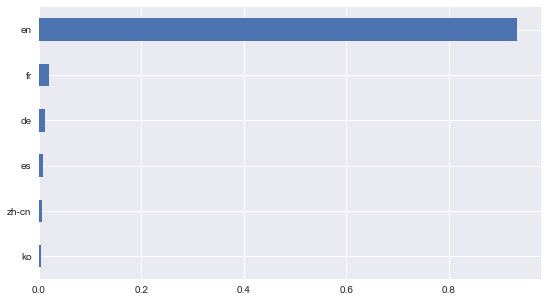

In [47]:
ax = df.language.value_counts(normalize=True).head(6).sort_values().plot(kind='barh', figsize=(9,5));

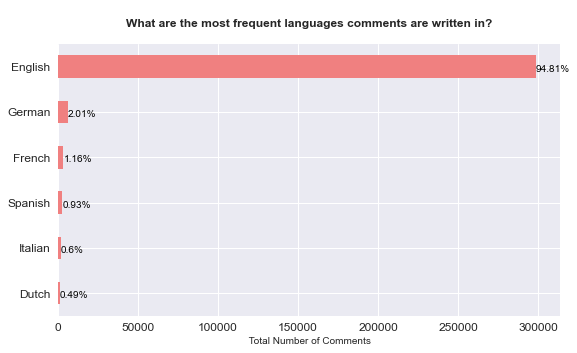

In [48]:
# visualizing the comments' languages b) neat and clean
ax = df.language.value_counts().head(6).plot(kind='barh', figsize=(9,5), color="lightcoral", 
                                             fontsize=12);

ax.set_title("\nWhat are the most frequent languages comments are written in?\n", 
             fontsize=12, fontweight='bold')
ax.set_xlabel(" Total Number of Comments", fontsize=10)
ax.set_yticklabels(['English', 'German', 'French', 'Spanish', 'Italian', 'Dutch'])

# create a list to collect the plt.patches data
totals = []
# find the ind. values and append to list
for i in ax.patches:
    totals.append(i.get_width())
# get total
total = sum(totals)

# set individual bar labels using above list
for i in ax.patches:
    ax.text(x=i.get_width(), y=i.get_y()+.35, 
            s=str(round((i.get_width()/total)*100, 2))+'%', 
            fontsize=10, color='black')

# invert for largest on top 
ax.invert_yaxis()

In [64]:
# as we are only interested in comments written in english, we need to split the data to english related sub-dataframes
df_eng = df[(df['language']=='en')]

In [60]:
#save df_eng to pkl files to reduce loading time 
reviews=reviews.drop(['language'], axis=1)
df_eng.to_pickle("df_eng.pkl")

In [74]:
df_eng.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,958,5977,2009-07-23,15695,Edmund C,"Our experience was, without a doubt, a five st..."
1,958,6660,2009-08-03,26145,Simon,Returning to San Francisco is a rejuvenating t...
2,958,11519,2009-09-27,25839,Denis,We were very pleased with the accommodations a...
3,958,16282,2009-11-05,33750,Anna,We highly recommend this accomodation and agre...
4,958,26008,2010-02-13,15416,Venetia,Holly's place was great. It was exactly what I...


In [44]:
reviews = pd.read_pickle("df_eng.pkl")

In [45]:
#remove commens with 2 alphabets and less
reviews["comments_cleansed"] = reviews.comments.str.replace(r'\b(\w{1,2})\b', '')

In [46]:
#Remove non-letters and change to lower case:
stemmer = PorterStemmer()
#remove stop words, tokenise the text data
stop_words = set(stopwords.words('english'))

def preprocess(review):
    review = " ".join([stemmer.stem(w.lower()) for w in word_tokenize(re.sub('[^a-zA-Z]+', ' ', review.replace("<br />", ""))) if not w in stop_words])
    return review

reviews['comments_cleansed'] = reviews.apply(lambda x: preprocess(x['comments_cleansed']), axis=1)

In [47]:
my_stop_words = ["".join(reviews.comments_cleansed[idx]) for idx in reviews.index]

In [23]:
# getting only the negative score
def negative_score(text):
    negative_value = analyzer.polarity_scores(text)['neg']
    return negative_value

# getting only the neutral score
def neutral_score(text):
    neutral_value = analyzer.polarity_scores(text)['neu']
    return neutral_value

# getting only the positive score
def positive_score(text):
    positive_value = analyzer.polarity_scores(text)['pos']
    return positive_value

# getting only the compound score
def compound_score(text):
    compound_value = analyzer.polarity_scores(text)['compound']
    return compound_value

In [78]:
%%time

reviews['sentiment_neg'] = reviews['comments'].apply(negative_score)
reviews['sentiment_neu'] = reviews['comments'].apply(neutral_score)
reviews['sentiment_pos'] = reviews['comments'].apply(positive_score)
reviews['sentiment_compound'] = reviews['comments'].apply(compound_score)

Wall time: 31min 45s


In [84]:
df = reviews
df=df.drop(['reviewer_id'], axis=1)
df=df.drop(['reviewer_name'], axis=1)
df=df.drop(['date'], axis=1)

In [3]:
#df.to_pickle("df_sentiment.pkl")
df =pd.read_pickle("df_sentiment.pkl")

In [4]:
df.head()

,listing_id,id,comments,comments_cleansed,sentiment_neg,sentiment_neu,sentiment_pos,sentiment_compound
0,958,5977,"Our experience was, without a doubt, a five st...",experi without doubt five star experi holli hu...,0.000,0.788,0.212,0.9590
1,958,6660,Returning to San Francisco is a rejuvenating t...,return francisco rejuven thrill time enhanc st...,0.000,0.697,0.303,0.9819
2,958,11519,We were very pleased with the accommodations a...,pleas accommod friendli neighborhood be abl ma...,0.134,0.710,0.156,0.7600
3,958,16282,We highly recommend this accomodation and agre...,highli recommend accomod agre previou post hol...,0.035,0.646,0.319,0.9840
4,958,26008,Holly's place was great. It was exactly what I...,holli place great exactli need perfect locat s...,0.000,0.613,0.387,0.9617


In [5]:
def label_sentiment (df):
    if df['sentiment_compound'] >= 0.05 :
        return 1
    return 0

def sentiment_type (df):
    if df['sentiment_compound'] >= 0.05 :
        return "positive"
    if df['sentiment_compound'] >= -0.05 :
        return "neutral"
    if df['sentiment_compound'] <= -0.05 :
        return "negative"

In [6]:
df['sentiment_label'] = df.apply(label_sentiment, axis=1)

df['sentiment_type'] = df.apply(label_sentiment, axis=1)

In [54]:
df.head

<bound method NDFrame.head of         listing_id         id  \
0              958       5977   
1              958       6660   
2              958      11519   
3              958      16282   
4              958      26008   
...            ...        ...   
320623    44554195  649112168   
320624    44554195  649140249   
320625    44554195  649170022   
320626    44554195  649218478   
320627    44554195  649614164   

                                                 comments  \
0       Our experience was, without a doubt, a five st...   
1       Returning to San Francisco is a rejuvenating t...   
2       We were very pleased with the accommodations a...   
3       We highly recommend this accomodation and agre...   
4       Holly's place was great. It was exactly what I...   
...                                                   ...   
320623  Cute, updated hotel in a very central area. Ea...   
320624  Skip this air bnb. To many cons . you won't en...   
320625                  

In [7]:
# full dataframe with POSITIVE comments
df_pos = df.loc[df.sentiment_compound >= 0.95]

# only corpus of POSITIVE comments
pos_comments = df_pos['comments'].tolist()

In [19]:
# full dataframe with NEGATIVE comments
df_neg = df.loc[df.sentiment_compound <= -0.05]

# only corpus of NEGATIVE comments
neg_comments = df_neg['comments'].tolist()

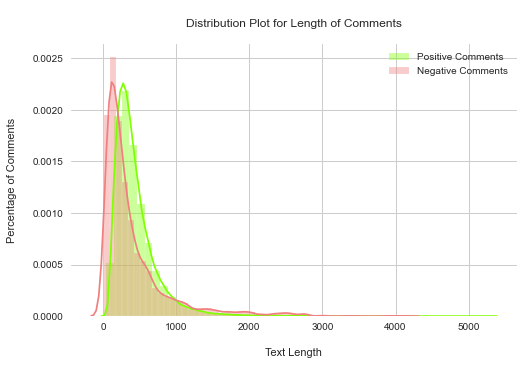

In [20]:
df_pos['text_length'] = df_pos['comments'].apply(len)
df_neg['text_length'] = df_neg['comments'].apply(len)
sns.set_style("whitegrid")
plt.figure(figsize=(8,5))

sns.distplot(df_pos['text_length'], kde=True, bins=50, color='chartreuse')
sns.distplot(df_neg['text_length'], kde=True, bins=50, color='lightcoral')

plt.title('\nDistribution Plot for Length of Comments\n')
plt.legend(['Positive Comments', 'Negative Comments'])
plt.xlabel('\nText Length')
plt.ylabel('Percentage of Comments\n');

### Clustering

In [2]:
reviews = reviews.to_pickle("reviews.pkl")
reviews = pd.read_pickle("reviews.pkl")